In [1]:
import os
import glob
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import matplotlib.pyplot as plt
from nflows import flows, transforms, distributions
from nflows.transforms.normalization import ActNorm
from tqdm import tqdm

from src.diffeomorphisms.image.nflow import NFlowImageDiffeomorphism
from src.dimension_reduction.principal_geodesic_analysis.image.l2_tangent_space_pca import l2TangentSpacePCAImageSolver
from src.manifolds.euclidean.image.pullback.standard import StandardPullbackImageEuclidean
from src.manifolds.euclidean.image.standard import StandardImageEuclidean
from src.manifolds.isometrized_euclidean.image import l2IsometrizedImageEuclidean
from src.transforms.multi_layer_parity_conv2d.tanh import MultiLayerTanhParityConv2DTransform
from src.transforms.parity_conv import ParityConv2DTransform

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set random seed for reproducibility
torch.manual_seed(31)

# Experiment settings
size = 28
results_folder = os.path.join("results",f"mnist_{size}x{size}","additive-tanh-isotropic-nflow-pullback")
train_model = False

plt.rcParams['font.size'] = 20  # Change this value to your desired font size

### Learning Geometry ###

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:14<00:00, 671732.69it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 314227.63it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:06<00:00, 261106.94it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 1050194.53it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



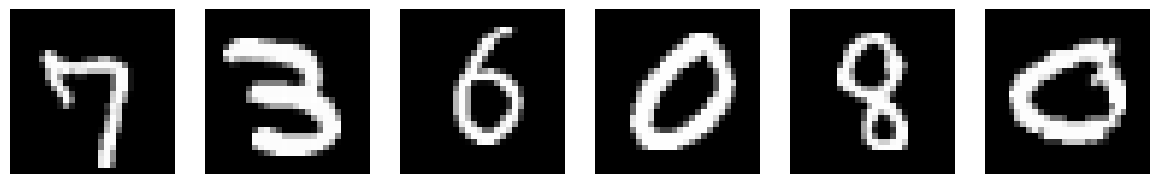

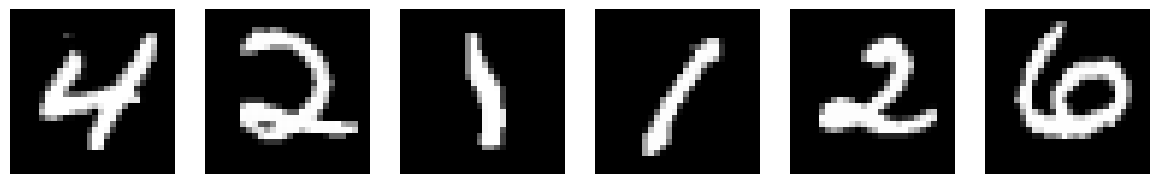

In [2]:
# Construct dataset
H, W = size, size
mnist_mean = 0.1307
mnist_var = 0.3081

# Define the transform
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((H, W)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((mnist_mean,), (mnist_var,))
])

# Load the full MNIST dataset
full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Calculate the split point (e.g., 80% for training, 20% for validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Create train and validation subsets
data_train, data_val = random_split(full_dataset, [train_size, val_size])

# Create the DataLoaders
batch_size = 128
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=False)

# Get a batch of examples from the training set
train_examples = next(iter(train_loader))
train_images, _ = train_examples
val_examples = next(iter(val_loader))
val_images, val_labels = val_examples

# Plot the first 6 images
fig, axes = plt.subplots(1, 6, figsize=(12, 8))
axes = axes.flatten()

for i in range(6):
    axes[i].imshow(train_images[i].squeeze(), cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Plot the first 6 images
fig, axes = plt.subplots(1, 6, figsize=(12, 8))
axes = axes.flatten()

for i in range(6):
    axes[i].imshow(val_images[i].squeeze(), cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [3]:
# Define the normalizing flow model
def create_flow_model(in_channels, height, width, kernel_size, latent_channels, order, n_flows, unit_det=False, parity_equivariance=False, actnorm=True):
    base_dist = distributions.StandardNormal(shape=[in_channels, height, width])
    transforms_list = []
    for i in range(n_flows):
        if actnorm:
            transforms_list.append(ActNorm(features=in_channels))
        transforms_list.append(ParityConv2DTransform(in_channels, height, width, kernel_size, parity=i, unit_det=unit_det, parity_equivariance=parity_equivariance))
        transforms_list.append(ParityConv2DTransform(in_channels, height, width, kernel_size, parity=i+1, unit_det=unit_det, parity_equivariance=parity_equivariance))
        transforms_list.append(MultiLayerTanhParityConv2DTransform(in_channels, height, width, kernel_size, latent_channels, order=order, parity=i))
    if actnorm:
            transforms_list.append(ActNorm(features=in_channels))
    transforms_list.append(ParityConv2DTransform(in_channels, height, width, kernel_size, parity=n_flows, unit_det=unit_det, parity_equivariance=parity_equivariance))
    transforms_list.append(ParityConv2DTransform(in_channels, height, width, kernel_size, parity=n_flows+1, unit_det=unit_det, parity_equivariance=parity_equivariance))
    flow_transforms = transforms.CompositeTransform(transforms_list)
    return flows.Flow(transform=flow_transforms, distribution=base_dist)

In [4]:
# Initialize the model
L = 128
K = 5
order = 6
n_flows = 6
model = create_flow_model(1, H, W, K, L, order, n_flows).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [5]:
# Generate samples
@torch.no_grad()
def generate_samples(model, n_samples):
    samples = model.sample(n_samples).cpu()
    return samples

In [6]:
# Training loop
def train(phi, train_loader, optimizer, n_epochs, save_dir='results', start_epoch=0):
    best_loss = float('inf')
    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(start_epoch, n_epochs):
        epoch_loss = 0
        for x, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
            optimizer.zero_grad()

            # Compute loss
            loss = -phi.nflow.log_prob(x.to(device)).mean()
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        
        # Calculate average loss for the epoch
        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{n_epochs}, Average Loss: {avg_epoch_loss:.4f}")

        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': phi.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'best_loss': best_loss,
        }
        
        if (epoch + 1) % 25 == 0:
            torch.save(checkpoint, os.path.join(save_dir, f'epoch_{epoch+1}_model.pth'))

        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            torch.save(checkpoint, os.path.join(save_dir, 'best_model.pth'))

    print("Training completed. Best model saved with loss:", best_loss)

In [7]:
# Train the model
n_epochs = 100

# Construct diffeomorphism
phi = NFlowImageDiffeomorphism(1, H, W, model)
checkpoint_dir = os.path.join(results_folder, f"checkpoints_latent_dim={L}_kernel_size={K}_order={order}_n_flows={n_flows}")

# Train or load model
if train_model:
    start_epoch = 0
    best_loss = float('inf')

    # Check if there's a checkpoint to resume from
    latest_checkpoint = max(glob.glob(os.path.join(checkpoint_dir, 'epoch_*_model.pth')), default=None, key=os.path.getctime)
    
    if latest_checkpoint:
        print(f"Resuming training from {latest_checkpoint}")
        checkpoint = torch.load(latest_checkpoint)
        phi.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_loss = checkpoint['best_loss']

    train(phi, train_loader, optimizer, n_epochs, save_dir=checkpoint_dir, start_epoch=start_epoch)
else:
    # best_model_path = os.path.join(checkpoint_dir, 'epoch_200_model.pth')
    best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
    checkpoint = torch.load(best_model_path,map_location=device)
    phi.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
phi.eval()

NFlowImageDiffeomorphism(
  (nflow): Flow(
    (_transform): CompositeTransform(
      (_transforms): ModuleList(
        (0): ActNorm()
        (1-2): 2 x ParityConv2DTransform(
          (conv2d): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        )
        (3): MultiLayerTanhParityConv2DTransform(
          (cnn): Sequential(
            (0): MaskedConv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (1): TanhActivation()
            (2): MaskedConv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (3): TanhActivation()
            (4): MaskedConv2d(128, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          )
        )
        (4): ActNorm()
        (5-6): 2 x ParityConv2DTransform(
          (conv2d): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        )
        (7): MultiLayerTanhParityConv2DTransform(
          (cnn): Sequential(
            (0): MaskedConv

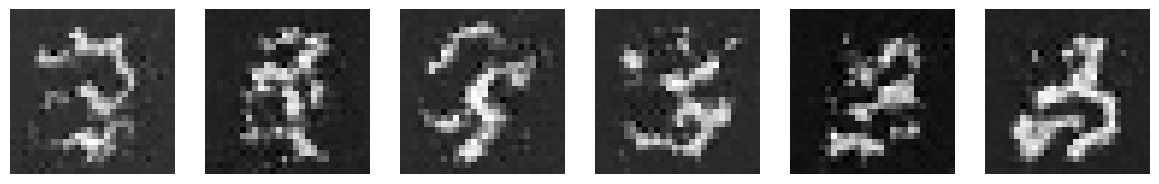

In [8]:
# Visualize generated samples
samples = generate_samples(phi.nflow, 100).reshape(-1,H,W)

# Plot the first 6 images
fig, axes = plt.subplots(1, 6, figsize=(12, 8))
axes = axes.flatten()

for i in range(6):
    axes[i].imshow(samples[i].squeeze(), cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# special points
num_points = 10
num_geodesics = 5

x0 = val_images[0:2*num_geodesics:2].to(device)
x1 = val_images[1:2*num_geodesics+1:2].to(device)

### Naive Riemannian data analysis ###

In [10]:
# Construct pullback manifold
manifold = StandardPullbackImageEuclidean(phi)

In [11]:
# Compute geodesics
t = torch.linspace(0., 1., num_points).to(device)

geodesics = torch.zeros(num_geodesics, num_points, 1, H, W)

# Generate geodesics
for i in range(num_geodesics):
    geodesics[i] = manifold.geodesic(x0[i], x1[i], t).detach().cpu()

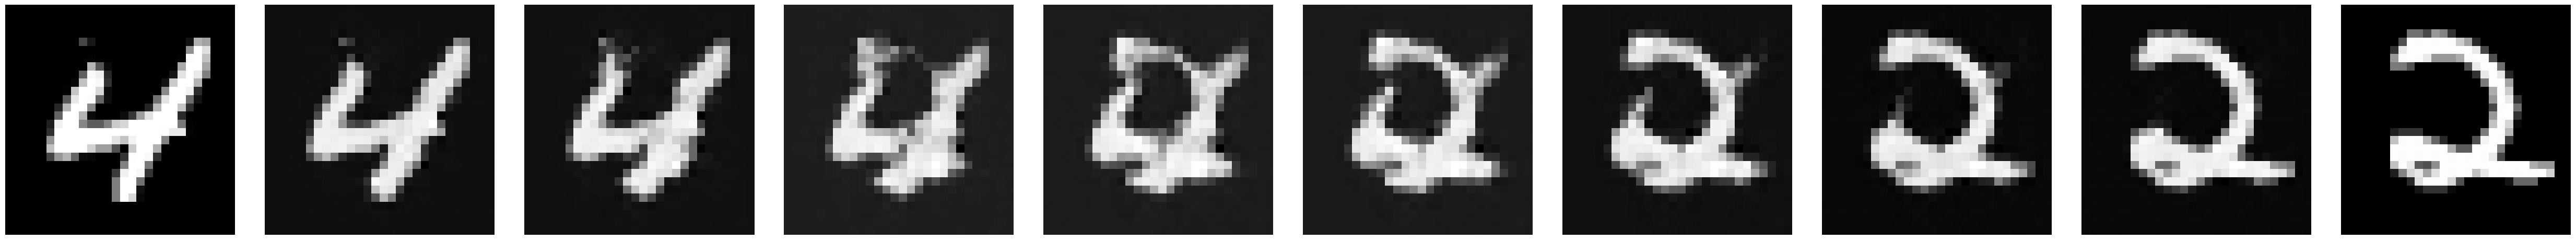

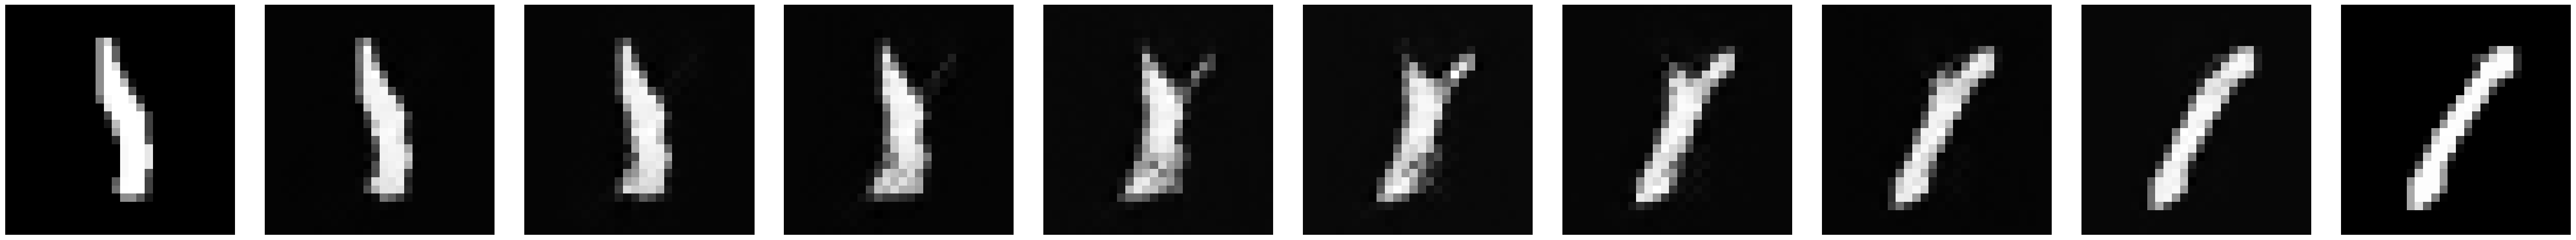

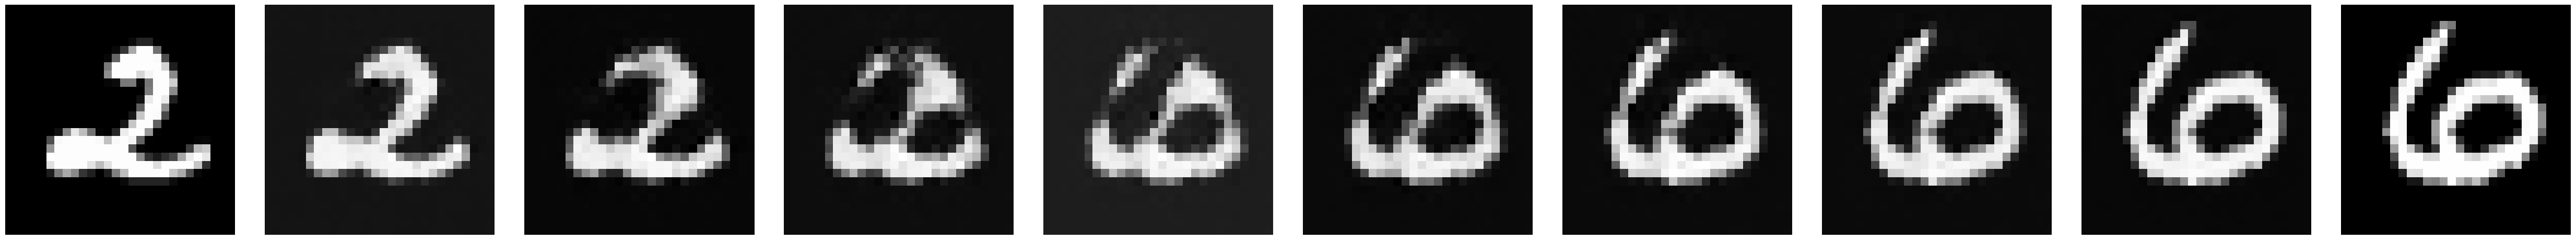

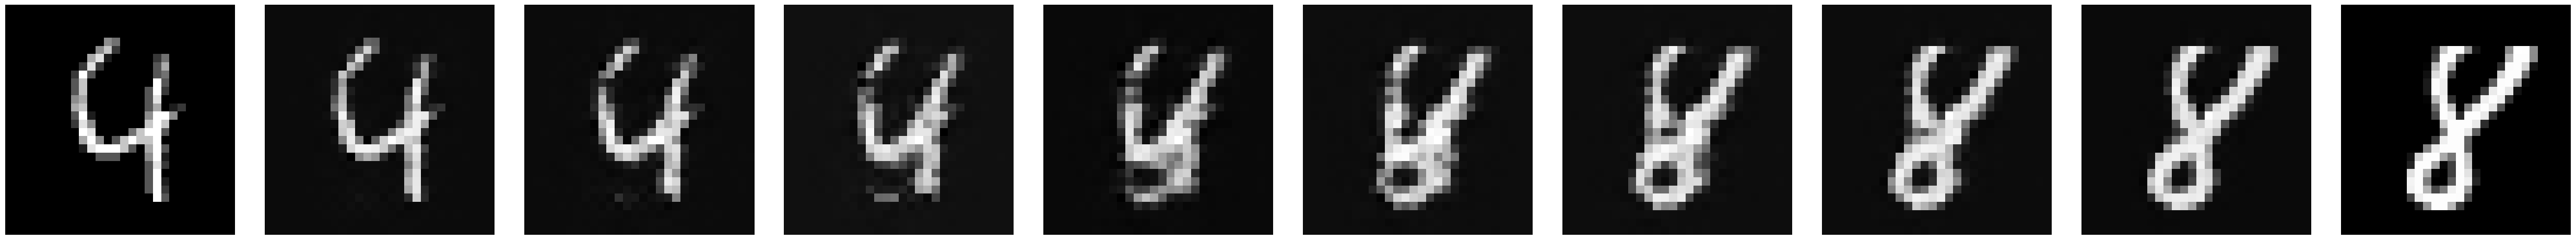

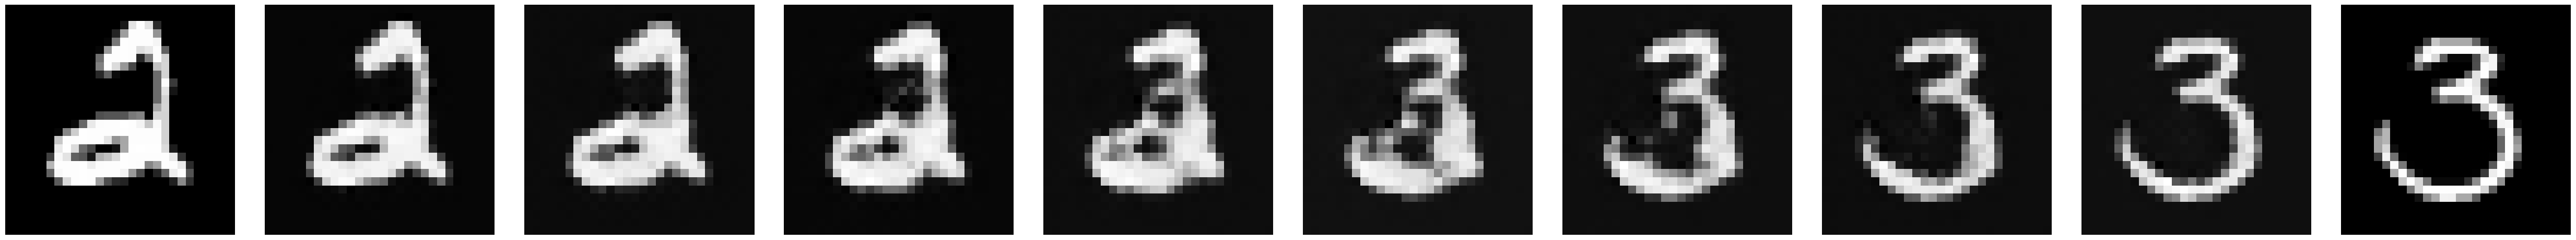

In [12]:
# Plot each image in the grid
for i in range(num_geodesics):
    fig, axes = plt.subplots(1,num_points, figsize=(5*num_points, 5))
    for j in range(num_points):
        axes[j].imshow(geodesics[i, j].squeeze(), cmap='gray')
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(results_folder,f"geodesic-{i}.eps"))
    plt.show()

In [13]:
# Compute barycentre
bary = manifold.barycentre(val_images.to(device)).detach().cpu()

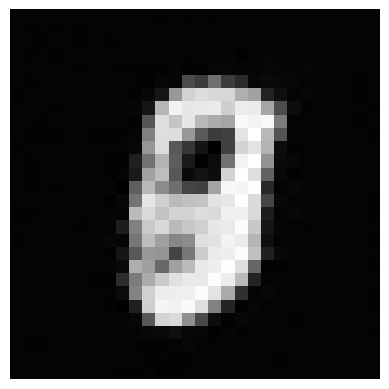

In [14]:
# Plot barycentres
plt.imshow(bary.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

In [15]:
# Construct curvature corrected l2-pga solver
l2_pga_solver = l2TangentSpacePCAImageSolver(val_images.to(device), manifold, bary.to(device))

In [16]:
# Compute low rank approximations
Xi_bary, exp_bary_Xi, _ = l2_pga_solver.solve(20)

Computing rank 20 approximation on tangent space
Computing rank 20 approximation on euclidean space
Computing rank 20 errors


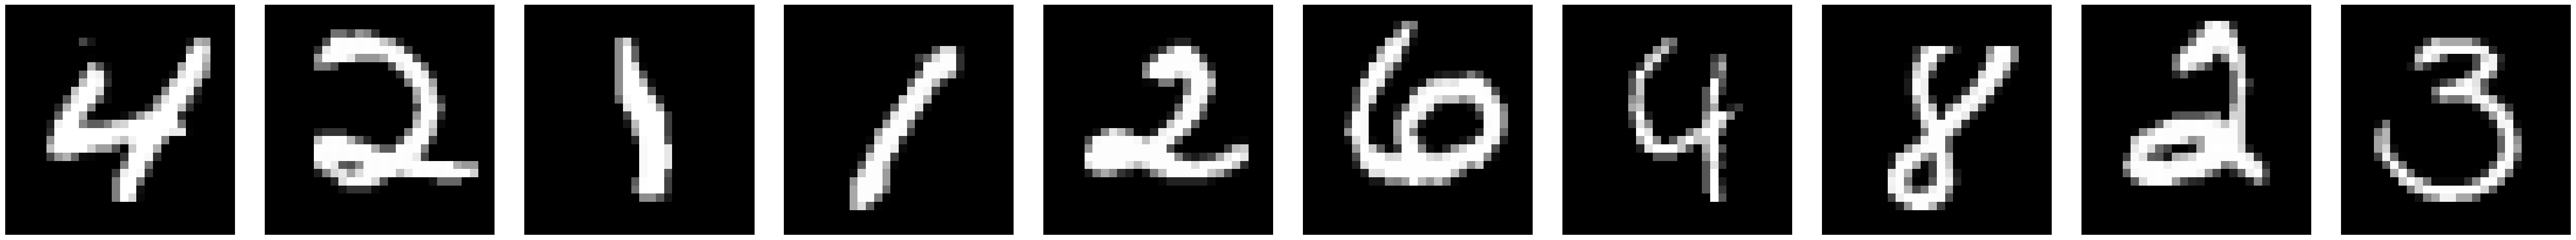

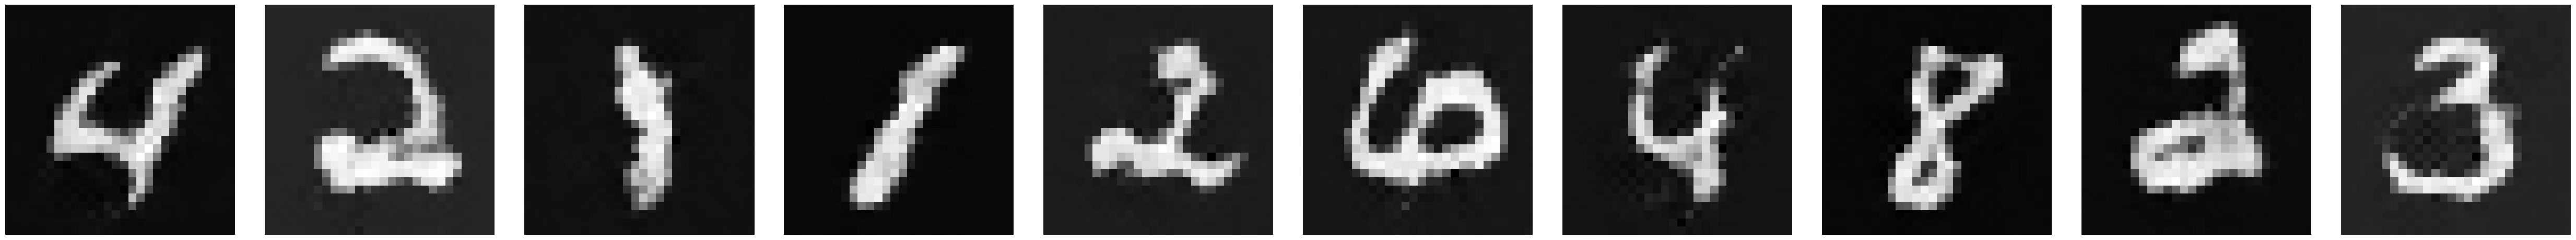

In [17]:
# Plot the first 6 images
fig, axes = plt.subplots(1, num_points, figsize=(5*num_points, 5))
axes = axes.flatten()
for i in range(num_points):
    axes[i].imshow(val_images[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_folder,"val-l2-pga.eps"))
plt.show()

fig, axes = plt.subplots(1, num_points, figsize=(5*num_points, 5))
axes = axes.flatten()
for i in range(num_points):
    axes[i].imshow(exp_bary_Xi.squeeze().detach().cpu().numpy()[i], cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_folder,"l2-pga.eps"))
plt.show()

### Isometrized Riemannian data analysis ###

In [18]:
# Construct isometrized pullback manifold
iso_manifold = l2IsometrizedImageEuclidean(manifold, num_intervals=100)

In [19]:
# Compute geodesics
t = torch.linspace(0., 1., num_points).to(device)

iso_geodesics = torch.zeros(num_geodesics, num_points, 1, H, W)

# Generate geodesics
for i in range(num_geodesics):
    iso_geodesics[i] = iso_manifold.geodesic(x0[i], x1[i], t).detach().cpu()

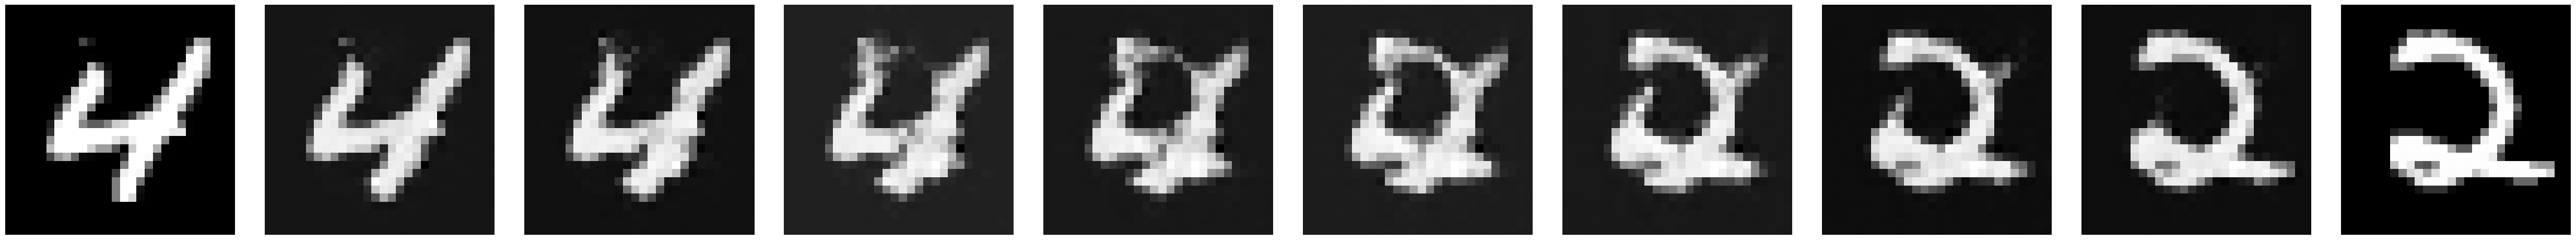

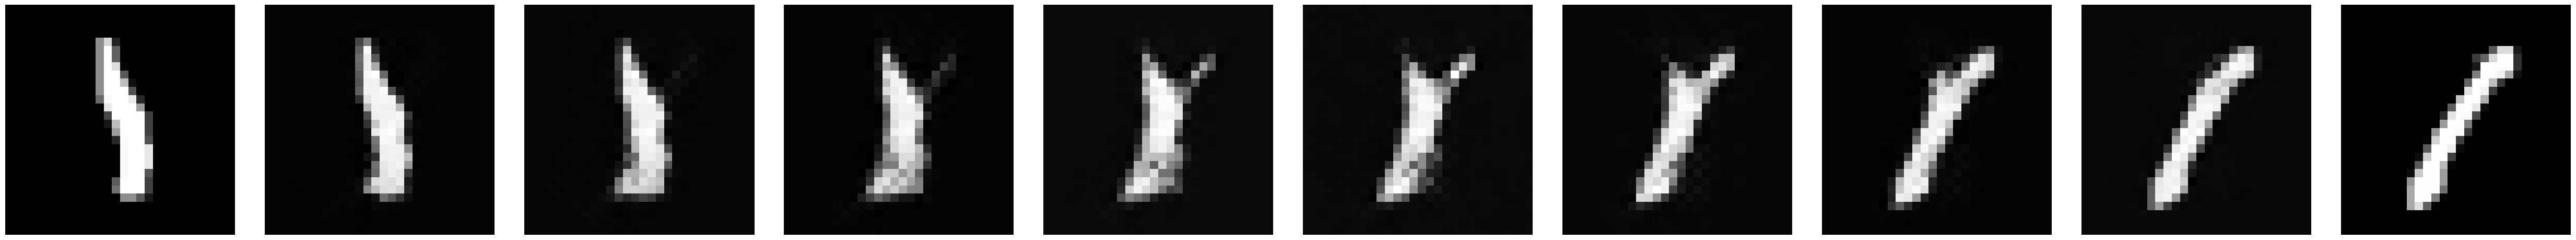

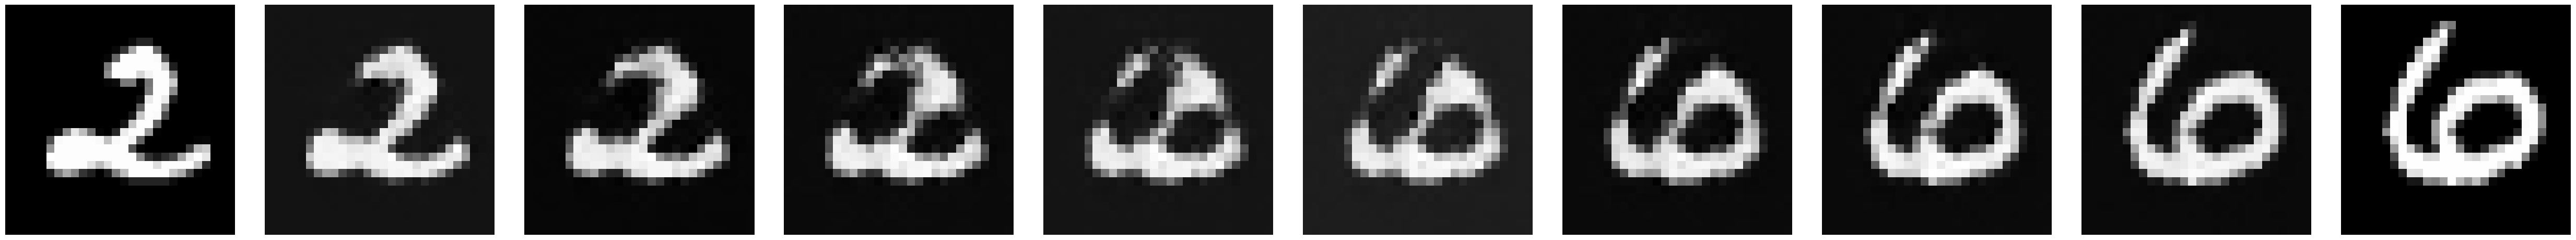

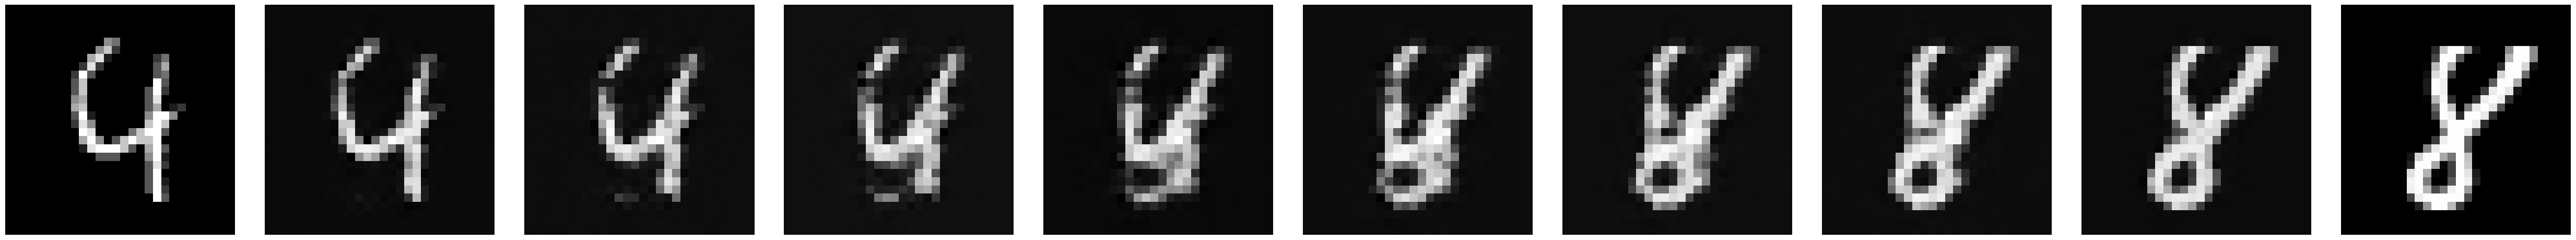

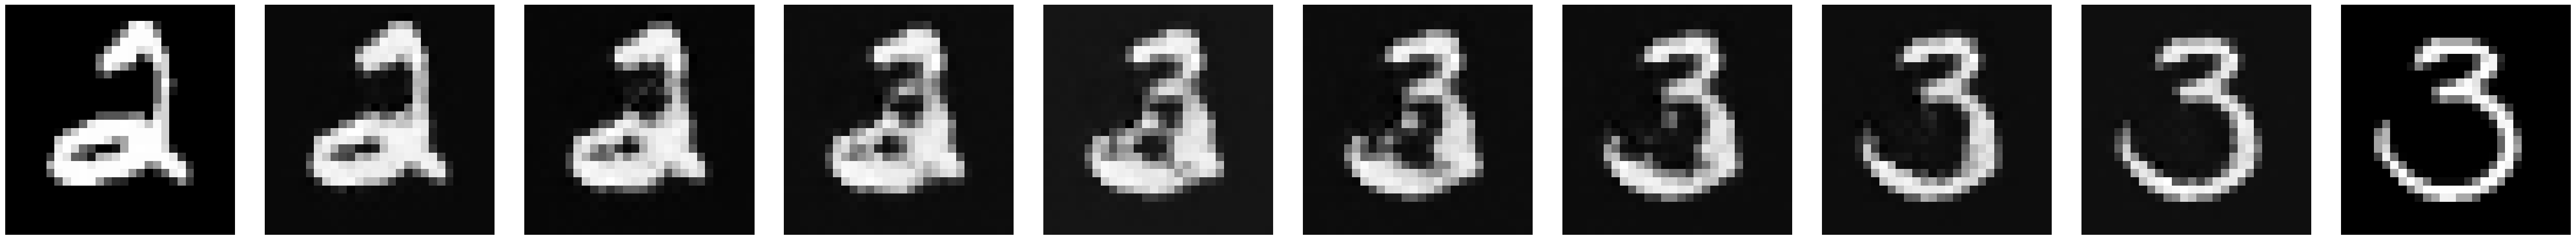

In [20]:
# Plot each image in the grid
for i in range(num_geodesics):
    fig, axes = plt.subplots(1, num_points, figsize=(5*num_points, 5))
    for j in range(num_points):
        axes[j].imshow(iso_geodesics[i, j].squeeze(), cmap='gray')
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(results_folder,f"iso-geodesic-{i}.eps"))
    plt.show()

In [21]:
# Construct curvature corrected l2-pga solver
iso_l2_pga_solver = l2TangentSpacePCAImageSolver(val_images.to(device), iso_manifold, bary.to(device))

KeyboardInterrupt: 

In [ ]:
# Compute low rank approximations
iso_Xi_bary, iso_exp_bary_Xi, _ = iso_l2_pga_solver.solve(20)

Computing rank 20 approximation on tangent space
Computing rank 20 approximation on euclidean space


Computing rank 20 errors


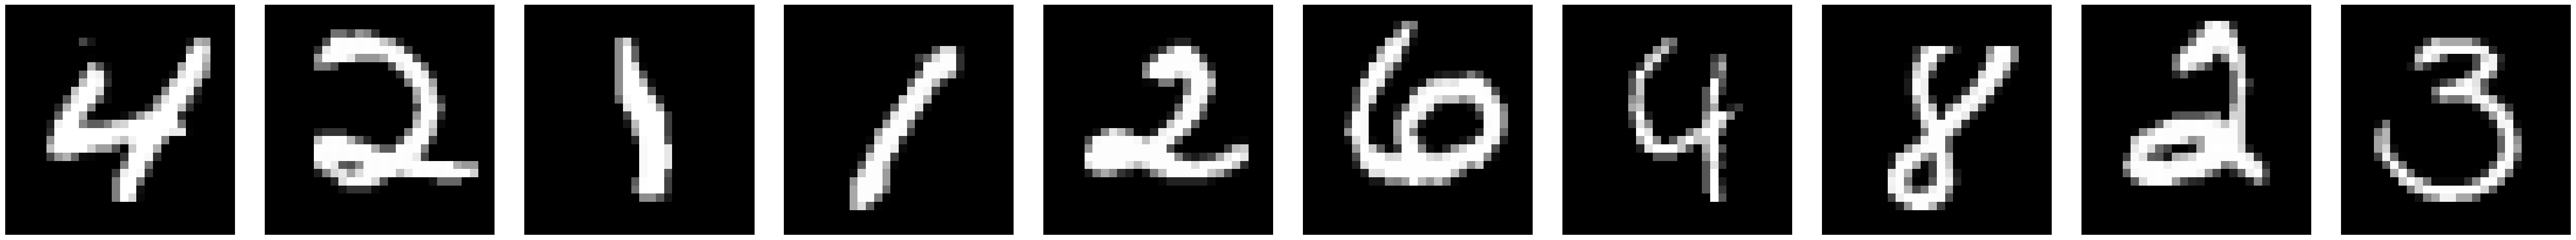

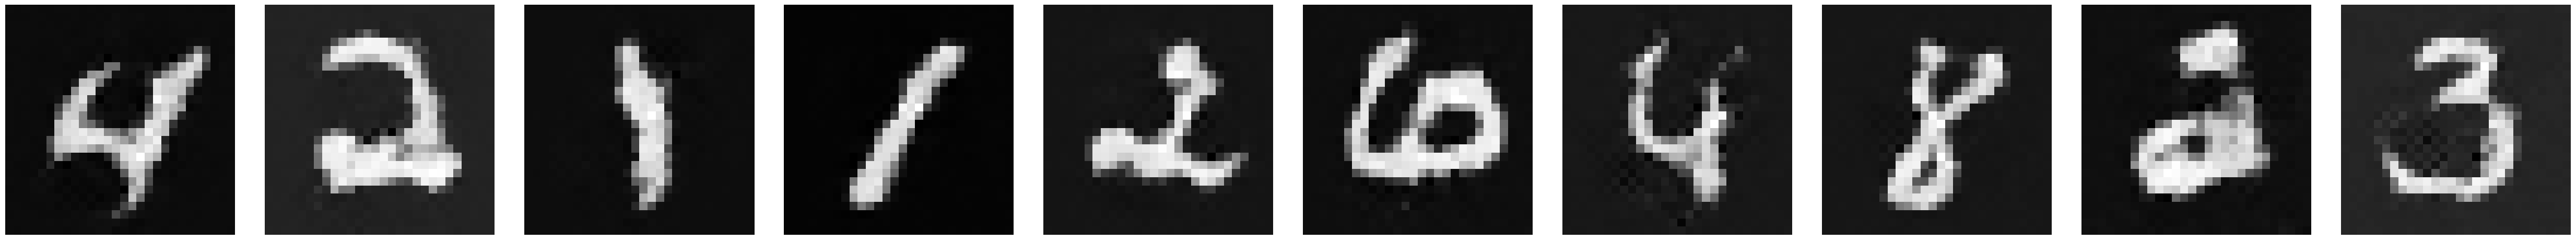

In [ ]:
# Plot the first 6 images
fig, axes = plt.subplots(1, num_points, figsize=(5*num_points, 5))
axes = axes.flatten()
for i in range(num_points):
    axes[i].imshow(val_images[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, num_points, figsize=(5*num_points, 5))
axes = axes.flatten()
for i in range(num_points):
    axes[i].imshow(iso_exp_bary_Xi.squeeze().detach().cpu().numpy()[i], cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_folder,"iso-l2-pga.eps"))
plt.show()

### l2 data analysis ###

In [ ]:
# Construct isometrized pullback manifold
l2_manifold = StandardImageEuclidean(1, H, W)

In [ ]:
# Compute geodesics
t = torch.linspace(0., 1., num_points).to(device)

l2_geodesics = torch.zeros(num_geodesics, num_points, 1, H, W)

# Generate geodesics
for i in range(num_geodesics):
    l2_geodesics[i] = l2_manifold.geodesic(x0[i], x1[i], t).detach().cpu()

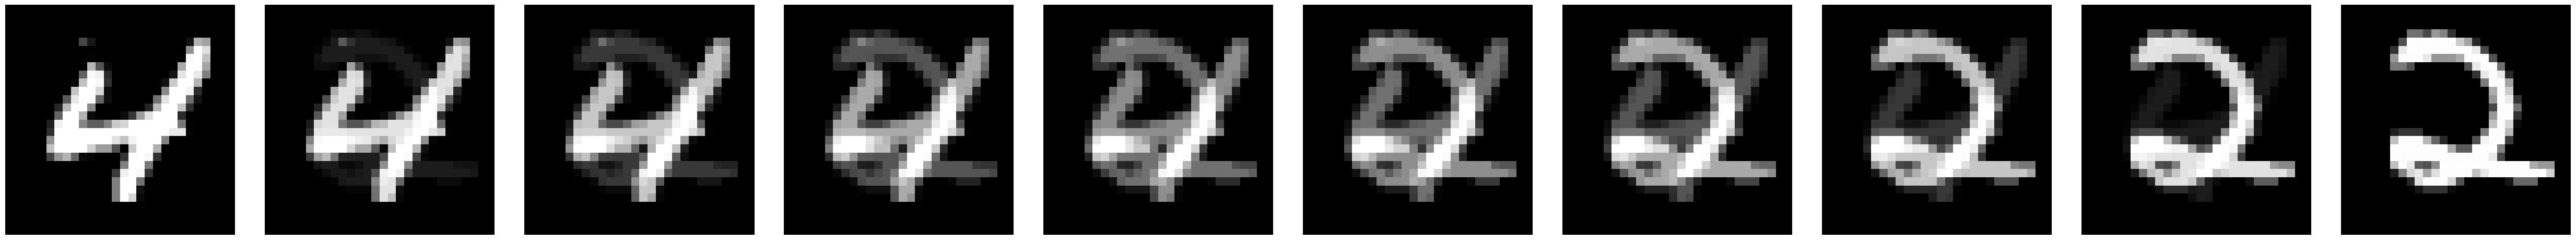

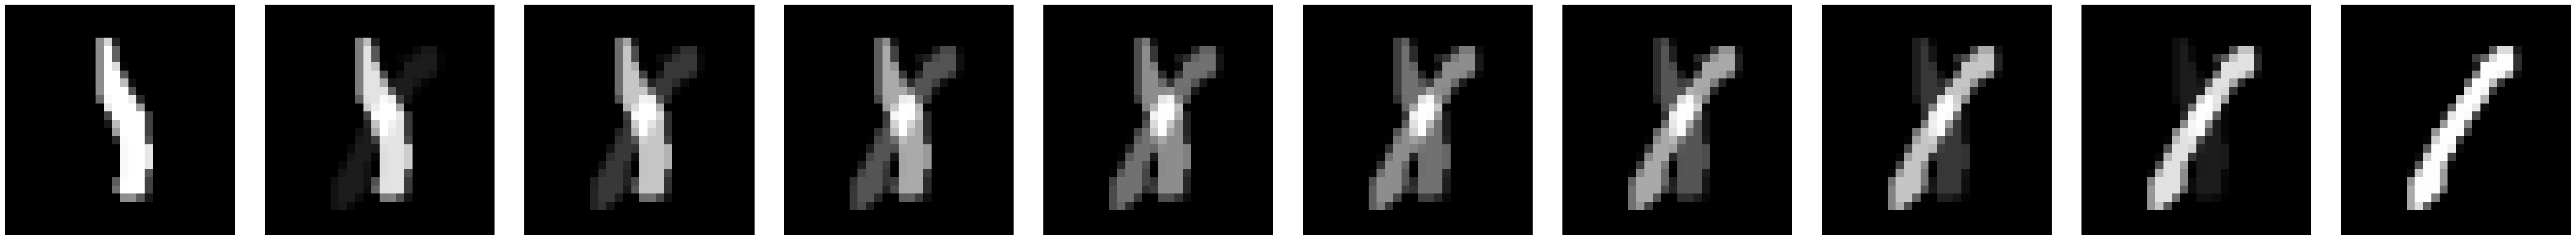

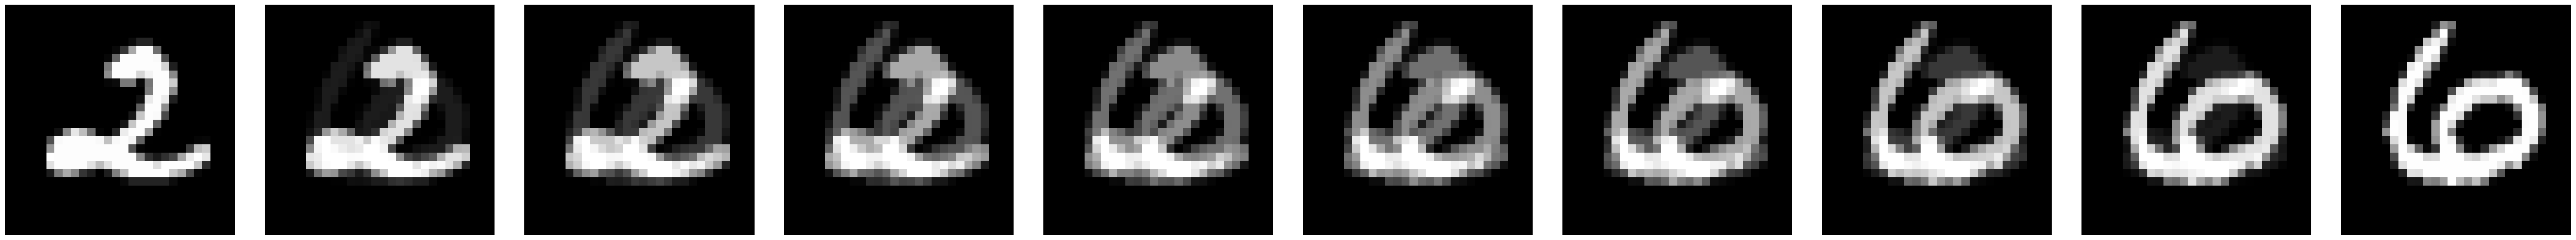

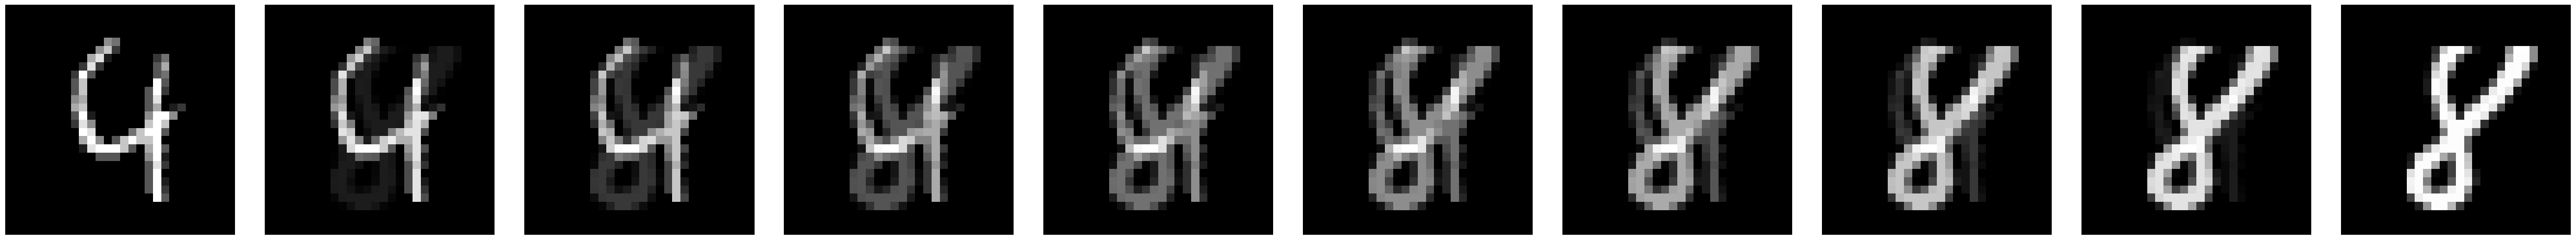

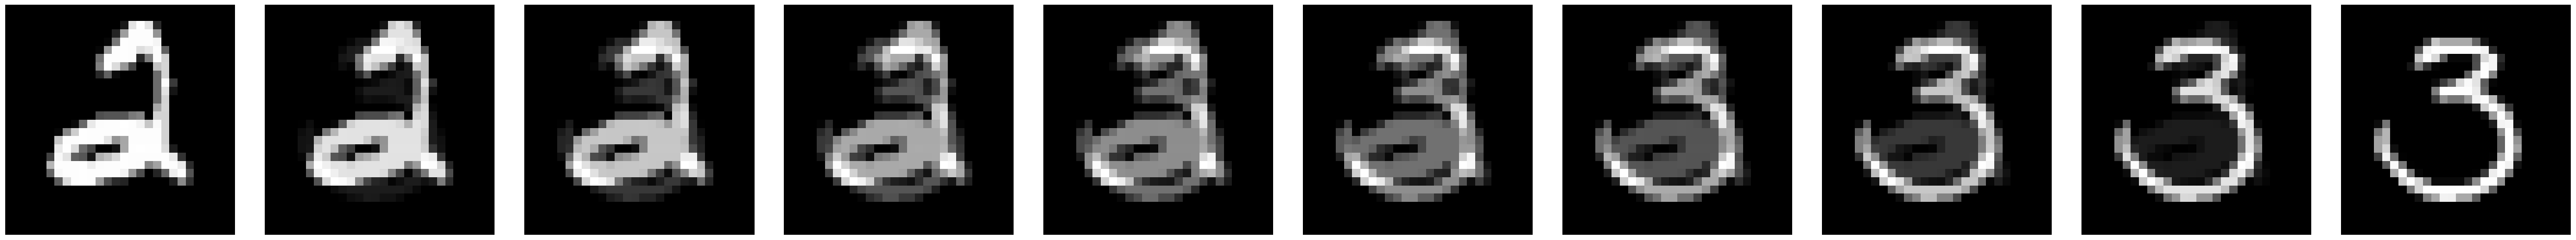

In [ ]:
# Plot each image in the grid
for i in range(num_geodesics):
    fig, axes = plt.subplots(1, num_points, figsize=(5*num_points, 5))
    for j in range(num_points):
        axes[j].imshow(l2_geodesics[i, j].squeeze(), cmap='gray')
        axes[j].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(results_folder,f"l2-geodesic-{i}.eps"))
    plt.show()

In [ ]:
# Construct curvature corrected l2-pga solver
l2_pca_solver = l2TangentSpacePCAImageSolver(val_images.to(device), l2_manifold, bary.to(device))

In [ ]:
# Compute low rank approximations
l2_Xi_bary, l2_exp_bary_Xi, _ = l2_pca_solver.solve(20)

Computing rank 20 approximation on tangent space
Computing rank 20 approximation on euclidean space
Computing rank 20 errors


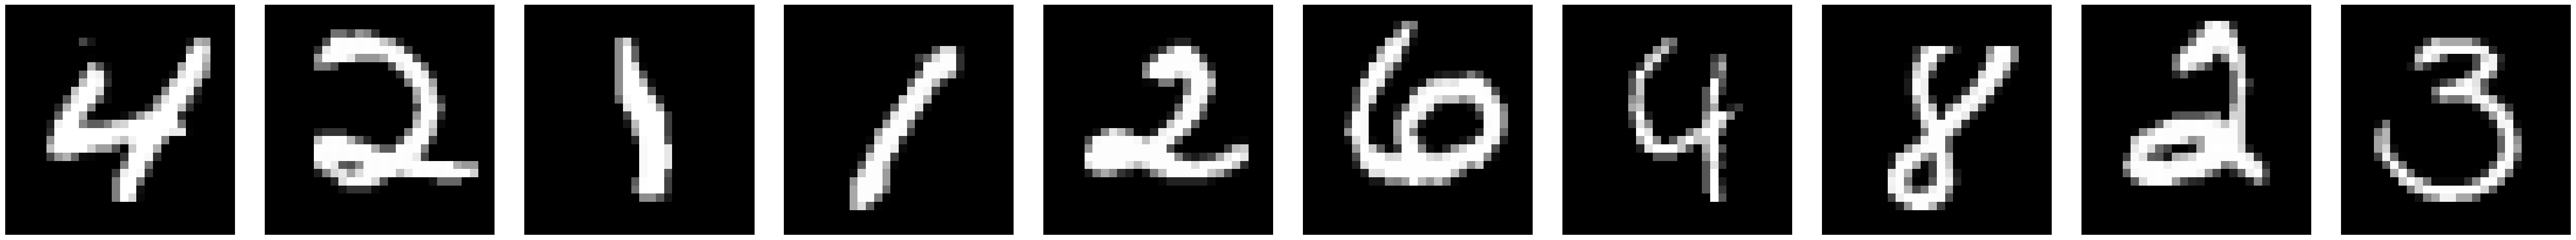

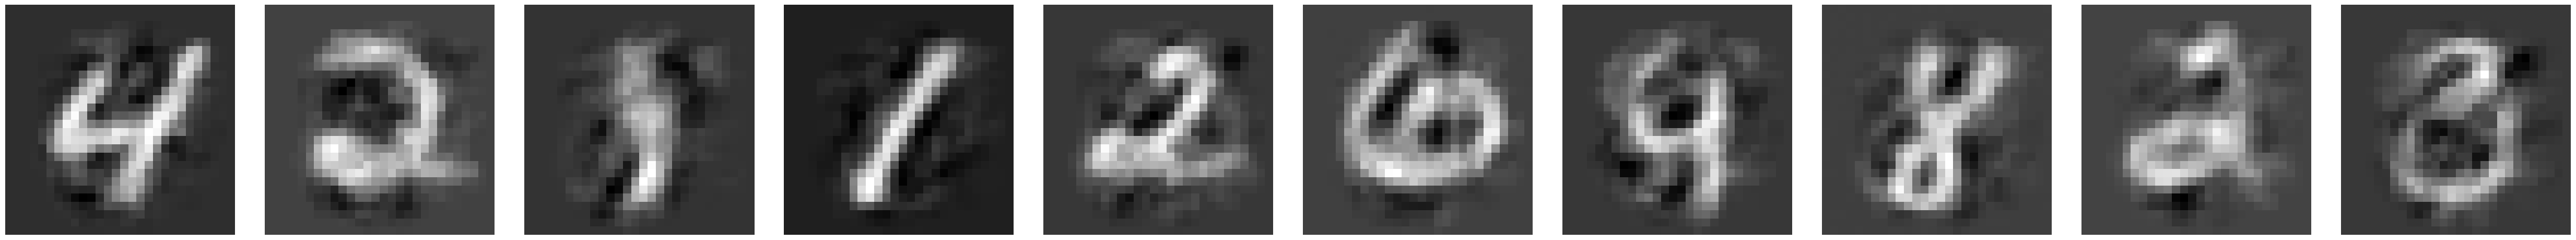

In [ ]:
# Plot the first 6 images
fig, axes = plt.subplots(1, num_points, figsize=(5*num_points, 5))
axes = axes.flatten()
for i in range(num_points):
    axes[i].imshow(val_images[i].squeeze(), cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, num_points, figsize=(5*num_points, 5))
axes = axes.flatten()
for i in range(num_points):
    axes[i].imshow(l2_exp_bary_Xi.squeeze().detach().cpu().numpy()[i], cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(results_folder,"l2-pca.eps"))
plt.show()

### Comparing naive and isometrized ###

In [ ]:
# Compute geodesic relative rmse from the barycentre
squared_geo_errors = torch.zeros(batch_size)
dists = ((val_images - bary)**2).sum([1,2,3])
for i, x_i in enumerate(val_images):
    geodesic_i = manifold.geodesic(bary.to(device), x_i.to(device), t).detach().cpu()
    iso_geodesic_i = iso_manifold.geodesic(bary.to(device), x_i.to(device), t).detach().cpu()
    squared_geo_errors[i] = ((geodesic_i - iso_geodesic_i)**2).mean(0).sum()

geo_rel_rmse = (squared_geo_errors.mean() / dists.mean()).sqrt()
print(geo_rel_rmse)

tensor(0.1497)


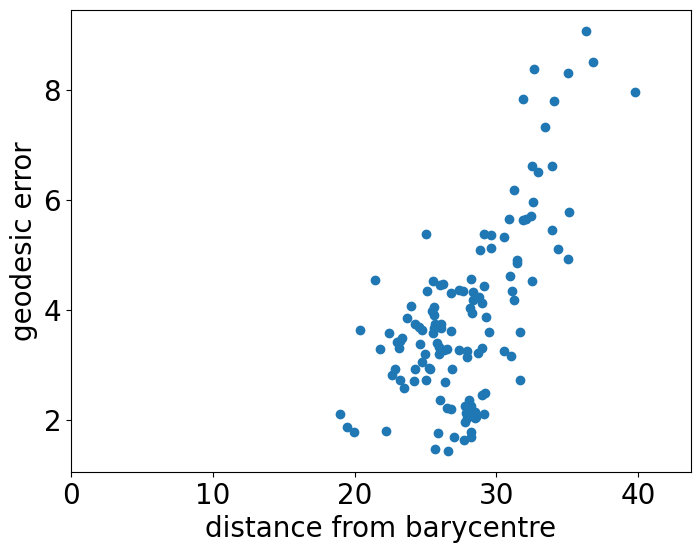

In [ ]:
# Make scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(dists.sqrt(), squared_geo_errors.sqrt())
plt.xlim([0.,dists.sqrt().max()*1.1])
plt.xlabel('distance from barycentre')
plt.ylabel('geodesic error')
plt.savefig(os.path.join(results_folder,"geo-error.eps"))
plt.show()

In [ ]:
# Compute low rank relative rmse from the barycentre
squared_low_rank_errors = ((val_images - exp_bary_Xi.cpu())**2).sum([1,2,3])
low_rank_rel_rmse = (squared_low_rank_errors.mean() / dists.mean()).sqrt()

squared_low_rank_iso_errors = ((val_images - iso_exp_bary_Xi.cpu())**2).sum([1,2,3])
iso_low_rank_rel_rmse = (squared_low_rank_iso_errors.mean() / dists.mean()).sqrt()

print(low_rank_rel_rmse)
print(iso_low_rank_rel_rmse)

tensor(0.5147)
tensor(0.5042)


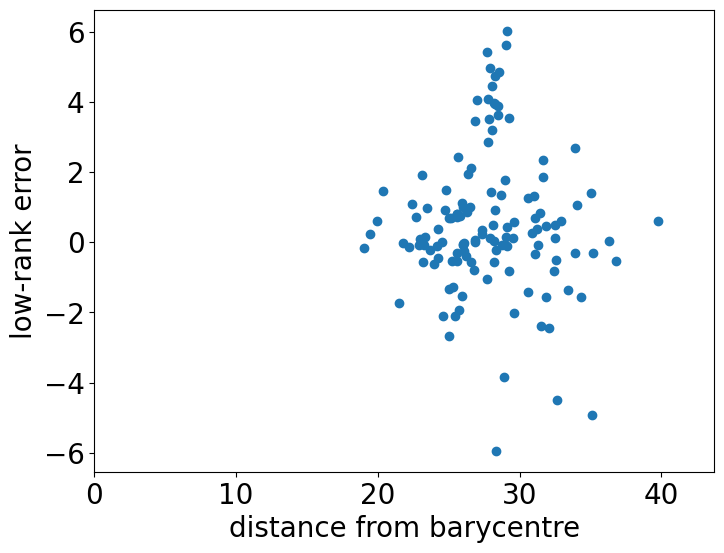

In [ ]:
# Make scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(dists.sqrt(), squared_low_rank_errors.sqrt() - squared_low_rank_iso_errors.sqrt())
plt.xlim([0.,dists.sqrt().max()*1.1])
plt.ylim([(squared_low_rank_errors.sqrt() - squared_low_rank_iso_errors.sqrt()).min()*1.1, (squared_low_rank_errors.sqrt() - squared_low_rank_iso_errors.sqrt()).max()*1.1])
plt.xlabel('distance from barycentre')
plt.ylabel('low-rank error')
plt.savefig(os.path.join(results_folder,"low-rank-error.eps"))
plt.show()